In [1]:
import os
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy import special as sp
import SimpleITK as sitk

from src.models.layers import SHConv3DRadial, BSHConv3D, SSHConv3D

In [2]:
image_sitk = sitk.ReadImage("/home/valentin/python_wkspce/petct-seg/data/processed/CHGJ074_ct.nii.gz")

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
layer = BSHConv3D(1, 5, max_degree=5, padding="valid", initializer=tf.keras.initializers.Constant(value=1.0),  project=False)

In [5]:
sh_filters = layer.conv_sh.filters
sh_filters.shape

AttributeError: 'SHConv3DRadial' object has no attribute 'w0'

NameError: name 'sh_filters' is not defined

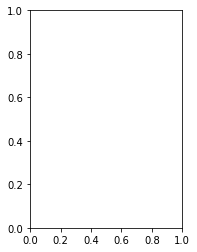

In [6]:
n_filter = 1
axis = "x-y"
# axis = "x-z"
if axis == "x-y":
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(sh_filters[:, :, 2, 0, 0, n_filter]))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.imag(sh_filters[:, :, 2, 0, 0, n_filter]))
    plt.colorbar()
else:
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(sh_filters[:, 2, :, 0, 0, n_filter]))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.imag(sh_filters[:, 2, :, 0, 0, n_filter]))
    plt.colorbar()


In [7]:
def rotate_3d(image, angle1, angle2, angle3):
    image = np.squeeze(image)
    image = rotate(image, -angle1, axes=(0, 1), reshape=False)
    image = rotate(image, angle2, axes=(1, 2), reshape=False)
    image = rotate(image, -angle3, axes=(0, 1), reshape=False)
    return image


def inv_rotate_3d(image, angle1, angle2, angle3):
    image = np.squeeze(image)
    image = rotate(image, angle3, axes=(0, 1), reshape=False)
    image = rotate(image, -angle2, axes=(1, 2), reshape=False)
    image = rotate(image, angle1, axes=(0, 1), reshape=False)
    return image

In [8]:
layer.indices[15]

(2, 2, 2)

In [9]:
layer.indices_inverse[(1,2,3)]
# layer.indices_inverse[1]

9

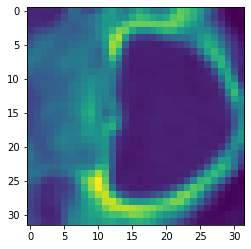

In [10]:
image = np.transpose(sitk.GetArrayFromImage(image_sitk), (2, 1, 0))
image = image[60:92, 60:92, 70:102]
plt.imshow(image[:, :, 15])

In [11]:
angle1, angle2, angle3 = 90, 90, 0
axes = (2, 1)
# image = np.random.uniform(size=(32, 32, 32))
image_rotated = rotate_3d(image, angle1, angle2, angle3)


In [12]:
image.shape

(32, 32, 32)

In [13]:
output = layer(image[np.newaxis, :, :, :, np.newaxis])
output_rotated = layer(image_rotated[np.newaxis, :, :, :, np.newaxis])

In [14]:
def check_output_diff(output):
    for k1 in range(output.shape[-1]):
        if np.sum(np.abs(output[...,k1]))==0:
            print(f"map {layer.indices[k1]} is zero")


In [15]:
output.shape

TensorShape([1, 28, 28, 28, 23])

In [16]:
check_output_diff(output)

In [17]:
layer.indices[4]

(1, 1, 0)

In [18]:
output.shape

TensorShape([1, 28, 28, 28, 23])

In [19]:
s = np.max(np.real(output), axis=(0,1,2,3))
for i in range(s.shape[-1]):
    print(f"{layer.indices[i]}: {s[i]}")

(0, 0, 0): 5688354930688.0
(0, 1, 1): 601410699264.0
(0, 2, 2): 241215340544.0
(0, 3, 3): 65423859712.0
(1, 1, 0): 31413394.0
(1, 1, 1): 992.6273193359375
(1, 1, 2): 61752385536.0
(1, 2, 1): 48046735360.0
(1, 2, 2): 864.0
(1, 2, 3): 17685622784.0
(1, 3, 2): 6411209216.0
(1, 3, 3): 184.0
(1, 3, 4): 7602788864.0
(2, 2, 0): 107874787328.0
(2, 2, 1): 429.3610534667969
(2, 2, 2): 44637224960.0
(2, 2, 3): 295.026611328125
(2, 2, 4): 30265528320.0
(2, 3, 1): 11577958400.0
(2, 3, 2): 512.0
(2, 3, 3): 5941633536.0
(2, 3, 4): 2214574080.0
(2, 3, 5): 3245891584.0


In [20]:
s[15]

44637225000.0

In [21]:
s = np.sum(np.imag(output), axis=(0,1,2,3))
for i in range(s.shape[-1]):
    print(f"{layer.indices[i]}: {s[i]}")

(0, 0, 0): 0.0
(0, 1, 1): 0.0
(0, 2, 2): 0.0
(0, 3, 3): 0.0
(1, 1, 0): 0.0
(1, 1, 1): 0.0
(1, 1, 2): 0.0
(1, 2, 1): 0.0
(1, 2, 2): 0.0
(1, 2, 3): 0.0
(1, 3, 2): 0.0
(1, 3, 3): 0.0
(1, 3, 4): 0.0
(2, 2, 0): 0.0
(2, 2, 1): 0.0
(2, 2, 2): 0.0
(2, 2, 3): 0.0
(2, 2, 4): 0.0
(2, 3, 1): 0.0
(2, 3, 2): 0.0
(2, 3, 3): 0.0
(2, 3, 4): 0.0
(2, 3, 5): 0.0


In [22]:
f_ind = layer.indices_inverse[(1, 1, 2)]
# f_ind = layer.indices_inverse[(2, 3, 5)]
fmap = output[0, :, :, :, f_ind]
fmap_rotated = output_rotated[0, :, :, :, f_ind]
fmap_unrotated = inv_rotate_3d(fmap_rotated, angle1, angle2, angle3)
# fmap_unrotated = rotate(fmap_rotated, -90, axes=(0, 1), reshape=False)

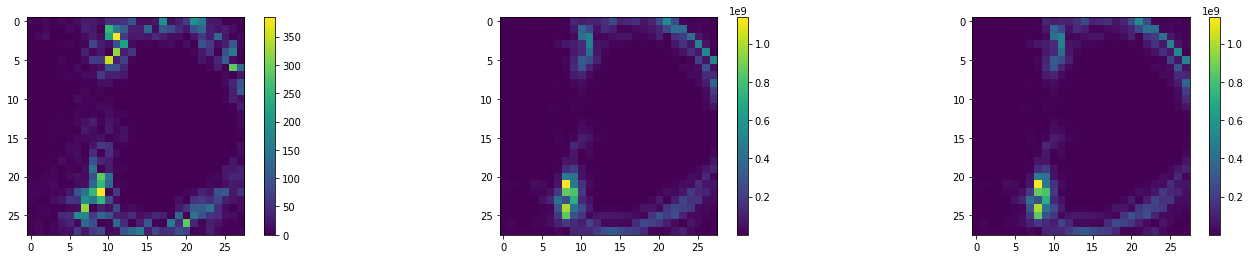

In [23]:
s = 15
difference = fmap - fmap_unrotated
plt.figure(figsize=(24, 4))
plt.subplot(131)
plt.imshow(np.abs(difference[:, :, s]))
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(fmap[:, :, s]))
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(fmap_unrotated[:, :, s]))
plt.colorbar()

In [ ]:
np.sum(fmap[...])

In [ ]:
kernel_size = 32
dirac = np.zeros((1, kernel_size, kernel_size, kernel_size, 1))
dirac[0, kernel_size // 2, kernel_size // 2, kernel_size // 2, 0] = 1
plt.imshow(dirac[0, :, :, kernel_size//2, 0])

In [ ]:
impulse_response = layer(dirac)

In [ ]:
layer.indices[7]

In [ ]:
plt.imshow(impulse_response[0, :, :, kernel_size // 2, 1])
plt.colorbar()

In [ ]:
impulse_response.shape

In [ ]:
filters = layer.conv_ch.filters